In [6]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

C:\Users\it\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 3000  # Size of the validation set
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 48  # Maximum number of words in a sequence
GLOVE_DIM = 50  # Number of dimensions of the GloVe word 
"""INPUT_PATH = '../input'  # Path where all input files are stored"""

"INPUT_PATH = '../input'  # Path where all input files are stored"

In [8]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

# import DATASET

In [9]:
import os
import sys
import pandas as pd
csv = 'dataset/cleand.csv'
data = pd.read_csv(csv,index_col=0, encoding='latin-1')
data.head()

,SentimentText,Sentiment
0,first think another disney movie might good it...,1
1,put aside dr house repeat missed desperate hou...,0
2,big fan stephen king s work film made even gre...,1
3,watched horrid thing tv needless say one movie...,0
4,truly enjoyed film acting terrific plot jeff c...,1


In [10]:
data.columns

Index(['SentimentText', 'Sentiment'], dtype='object')

In [11]:
import pandas as pd
df = pd.read_csv("dataset/cleand.csv")
df = df.reindex(np.random.permutation(df.index))  
df = df[['SentimentText', 'Sentiment']]
data.columns

Index(['SentimentText', 'Sentiment'], dtype='object')

In [12]:
from sklearn.cross_validation import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data.SentimentText, data.Sentiment, test_size=0.2, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_validation.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_validation.shape[0] == y_validation.shape[0]

# Train data samples: 20000
# Test data samples: 5000


C:\Users\it\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_validation)

In [14]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    20000.000000
mean       133.661800
std        100.701625
min          1.000000
25%         71.000000
50%         99.000000
75%        163.000000
max       1497.000000
Name: SentimentText, dtype: float64

In [15]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [16]:
X_train_seq_trunc[10]  # Example of padded sequence

array([ 123, 1224, 5341, 7044, 3247,  568,  153, 8017,    1,  275, 1517,
        284,  987, 5469, 1619,  385,  186, 2440, 5408, 3884,  890, 2455,
       5905, 9120,  688, 4041,  823,  222, 8018,  541,  729,  153, 5740,
        385, 1953, 8352, 1779,  142,   26, 4602,  754,  229, 3541, 3721,
       1919, 2172,  354,  988])

# Converting the target classes to numbers


In [17]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_validation)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

# Splitting off validation data¶

In [18]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.2, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (4000, 48)


# Modeling
Training word embeddings
Keras provides an Embedding layer which helps us to train specific word embeddings based on our training data. It will convert the words in our vocabulary to multi-dimensional vectors.

In [19]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(2, activation='softmax'))
emb_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 770       
Total params: 80,770
Trainable params: 80,770
Non-trainable params: 0
_________________________________________________________________


In [20]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 0s 25us/step - loss: 0.6862 - acc: 0.5788 - val_loss: 0.6730 - val_acc: 0.6588
Epoch 2/10
16000/16000 [==============================] - 0s 13us/step - loss: 0.6389 - acc: 0.7719 - val_loss: 0.6192 - val_acc: 0.7488
Epoch 3/10
16000/16000 [==============================] - 0s 12us/step - loss: 0.5610 - acc: 0.8238 - val_loss: 0.5462 - val_acc: 0.7820
Epoch 4/10
16000/16000 [==============================] - 0s 11us/step - loss: 0.4760 - acc: 0.8481 - val_loss: 0.4810 - val_acc: 0.8037
Epoch 5/10
16000/16000 [==============================] - 0s 13us/step - loss: 0.4034 - acc: 0.8668 - val_loss: 0.4321 - val_acc: 0.8162
Epoch 6/10
16000/16000 [==============================] - 0s 12us/step - loss: 0.3468 - acc: 0.8828 - val_loss: 0.4003 - val_acc: 0.8278
Epoch 7/10
16000/16000 [==============================] - 0s 13us/step - loss: 0.3043 - acc: 0.8960 - val_loss: 0.3788 - val_acc:

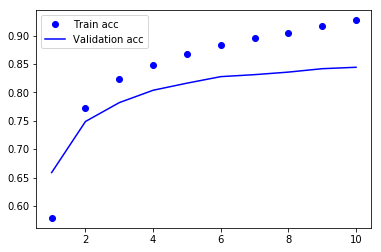

In [21]:
eval_metric(emb_history, 'acc')

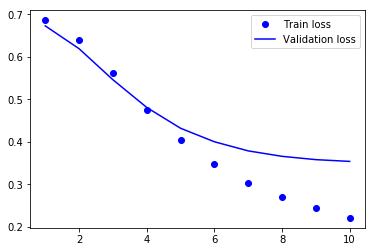

In [22]:
eval_metric(emb_history, 'loss')

In [23]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 2)




5000/5000 [==============================] - 0s 19us/step


In [24]:
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

Test accuracy of word embeddings model: 84.16%
